# Massively parallel ML assisted transition path sampling from equilibrium shooting points

## Notebook 2: Setup and run TPS simulation

This is the second of a series of example notebooks on massively parallel transition path sampling (TPS) using shooting points with a known equilibrium weight. If you have not done so, please have a look at and run the first notebook of the series, it must be run before this one.

In this notebook we will perform the actual TPS simulation. We will use the locally running `GmxEngine` and `PyTrajectoryFunctionWrapper` classes (such that you can run it on your workstation), but you can easily perform a massively parallel TPS on a HPC cluster running SLURM by using the `SlurmGmxEngine` and `SlurmTrajectoryFunctionWrapper` classes instead. However, in that case you will probably want to use a larger (and more interessting) system than capped alanine dipeptide :)

**This notebook should be run on a multi-core workstation preferably with a GPU**, otherwise you will have a very long coffee break and a very hot laptop.

**Required knowledge/recommended reading:** This notebooks assumes some familarity with the `asyncmd` (namely the [gromacs] engine and TrajectoryFunctionWrapper classes). Please see the example notebooks in `asyncmd` for an introduction.

## Imports and set working directory

In [1]:
%matplotlib inline

In [2]:
import os
import asyncio
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
# need asyncmd for the engine and trajectory classes
import asyncmd
import asyncmd.gromacs as asyncgmx
from asyncmd import Trajectory
# and aimmd for the TPS
import aimmd
import aimmd.distributed as aimmdd
# and some imports for the model
import torch.nn.functional as F
import torch

/home/tb/hejung/.conda/envs/aimmd_distributed_devel/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not initialize SLURM cluster handling. If you are sure SLURM (sinfo/sacct/etc) is available try calling `asyncmd.config.set_slurm_settings()` with the appropriate arguments.
Tensorflow/Keras not available


In [3]:
# setup working directory

scratch_dir = "/homeloc/scratch/aimmd_distributed/"
#scratch_dir = "."

workdir = os.path.join(scratch_dir, "TransitionPathSampling_with_EQ_SPs_ala")

if not os.path.isdir(workdir):
    os.mkdir(workdir)

## Setup logging to a file (optional)

The next few cells are just to show you how to configure pythons logging module to write to a logfile in the directory where we do the simulation. It is not necessary to run aimmd but it might be helpful to find out what went wrong if something does.

In [4]:
# setup logging
# executing this file sets the variable LOGCONFIG, which is a dictionary of logging presets 
%run ../resources/logconf.py

In [5]:
# have a look at the default logging level (the level used for the root logger)
print(LOGCONFIG["loggers"][""])
# have a look at the logger for aimmd
print(LOGCONFIG["loggers"]["aimmd"])
# and have a look at the log-level for the filehandler
print(LOGCONFIG["handlers"]["stdf"])
# the last two should both be `INFO`

{'level': 'WARN', 'handlers': ['stdf', 'warnout']}
{'level': 'INFO'}
{'class': 'logging.FileHandler', 'level': 'INFO', 'mode': 'w', 'filename': 'simulation.log', 'formatter': 'standardFormatter'}


In [6]:
# OPTIONAL: more logging to file
level = "INFO"
LOGCONFIG["handlers"]["stdf"]["level"] = level
LOGCONFIG["loggers"]["aimmd"]["level"] = level
LOGCONFIG["loggers"]["asyncmd"] = {"level": level}

In [7]:
# you can either modify single values or use it as is to get the same setup as in the OPS default logging config file
# you could e.g. do LOGCONF['handlers']['stdf']['filename'] = new_name to change the filename of the log
# the default is to create 'simulation.log' and 'initialization.log' in the current working directory
import logging.config
LOGCONFIG["handlers"]["stdf"]["filename"] = os.path.join(workdir, "simulation_pathsampling.log")
LOGCONFIG["handlers"]["initf"]["filename"] = os.path.join(workdir, "initlog_pathsampling.log")
logging.config.dictConfig(LOGCONFIG)

## Setup the TPS simulation

To setup the TPS simulation we need the following prerequistes:
 
 - Decide how many samplers we will run in parallel. The samplers are the objects/class that take care of the actual trial generation, i.e. using a larger number here means more parallel workload but shorter time to result as long as you are not resource limited (because the trial generation trivialy parallelizes).
 - Create a storage file so we can save our results and trained reaction coordinate models.
 - Define the metastable states (such that we know when to stop the intergation).
 - Define the underlying dynamics (by defining a gromacs engine and its parameters).
 - Define the set of shooting points and calculate their respective equilibrium weights (we will use the configurations from the umbrella sampling in the previous notebook).
 - Define the reaction coordinate model and the space it is learning in by choosing the `descriptor_transform` (which transforms from configurations to descriptor space)
 - Define the sampling scheme, i.e. how we generate new trials (here we will use two way shooting moves with random velocities).
 - Create a trainset into which we will add the simulation results (shooting outcomes).
 - Define the `Task`s to run after a specified number of trials. These are used to e.g. train the reaction coordinate model or save the trainset, model and brain at specified intervals. They are similar to the openpathsampling concept of hooks.

Then we finally put everything together and initialize a `Brain` with the defined variables. The `Brain` is the central object to interact with when running the TPS simulation according to your setup.

### Number of samplers

In [8]:
n_samplers = 5  # results in 2*n_samplers gmx engines running in parallel

### Create storage file

In [9]:
# create a storage file for our simulation results and reaction coordinate models
storage = aimmd.Storage(os.path.join(workdir, "storage.h5"))

### State functions

In [10]:
# import state functions
# these are python function returning True/False for every frame on a trajectory depending on if the frame is in the respective state
# they are defined in the file state_funcs_mda.py, you might want to have a look at it when writing your own state functions
# we will also directly import descriptor_func_psi_phi to calculate the weights below
# descriptor_func_psi_phi gives us the ψ and φ dihedral angles (we use it to project to a 2d space in which we can look at the TPE)
from state_funcs_mda import alpha_R, C7_eq, descriptor_func_psi_phi

# wrapp the state functions to make them awaitable
# (if you want to learn more about the TrajectoryFunctionWrappers have a look at the asyncmd example notebooks)
wrapped_alphaR = asyncmd.trajectory.PyTrajectoryFunctionWrapper(alpha_R)
wrapped_C7_eq = asyncmd.trajectory.PyTrajectoryFunctionWrapper(C7_eq)
wrapped_psi_phi = asyncmd.trajectory.PyTrajectoryFunctionWrapper(descriptor_func_psi_phi)

### Underlying dynamics

In [11]:
# Define the engine(s) for the PathMovers
# (they will all be the same, so we define it only once)
gro = "gmx_infiles/conf.gro"
top = "gmx_infiles/topol_amber99sbildn.top"
ndx = "gmx_infiles/index.ndx"
mdp = asyncgmx.MDP("gmx_infiles/md.mdp")

gmx_engine_kwargs = {"mdconfig": mdp,
                     "gro_file": gro,
                     "top_file": top,
                     "ndx_file": ndx,
                     "output_traj_type": "XTC",
                     #"mdrun_extra_args": "-nt 2",
                     # use this for gmx sans (thread) MPI
                     "mdrun_extra_args": "-ntomp 2",
                     }
gmx_engine_cls = asyncgmx.GmxEngine

### Shooting points and their equilibrium weights

Here we will use the configurations from the one umbrella window in the first notebook. This enables us to calculate equilibrium weights as $\exp(\beta V_{bias})$. We could naturaly instead use configurations from multiple differnt biasing potentials and would then obtain the equilibrium weights from running (binless) WHAM.

In [12]:
# define the US trajectory and calculate weights for reweighting to eq
path_to_us = "/homeloc/scratch/aimmd_distributed/UmbrellaSampling"

us_traj = asyncmd.Trajectory(structure_file=os.path.join(path_to_us, "US.tpr"),
                             trajectory_files=os.path.join(path_to_us, "US.part0001.xtc"))
us_mdp = asyncgmx.MDP(os.path.join(path_to_us, "US.mdp"))

psi_phi_us = await wrapped_psi_phi(us_traj)

# now calculate the weights
from scipy import constants

# read the values for force constant and potential zero point directly from the umbrella sampling mdp
T = us_mdp["ref-t"][0]
k_psi = float(us_mdp["pull-coord1-k"][0]) # kJ/ (mol * rad**2)
psi_0 = float(us_mdp["pull-coord1-init"][0]) * np.pi / 180  # psi_0 in rad
try:
    # make sure we do not crash if we biased only along ψ (and not also along φ)
    k_phi = float(us_mdp["pull-coord2-k"][0]) # kJ/ (mol * rad**2)
    phi_0 = float(us_mdp["pull-coord2-init"][0]) * np.pi / 180  # psi_0 in rad
except KeyError:
    k_phi = 0
    phi_0 = 0

# Note that gromacs uses the conventions:
#      U_bias = k/2 (x - x0)**2
#      F_bias = - k (x - x0)

def U_bias(x, x_0, k):
    return (k / 2.) * (x - x_0) * (x - x_0)

beta = 1000 / (constants.R * T)  # beta in kJ /mol

# we have just one umbrella window, the weights for the structures are just exp(\beta V_{bias})
# (as these are the weights one would use to get out the Boltzmann distribution on the original PES) 
weights = np.exp(beta * ( U_bias(psi_phi_us[:, 0], psi_0, k_psi) + U_bias(psi_phi_us[:, 1], phi_0, k_phi) ))

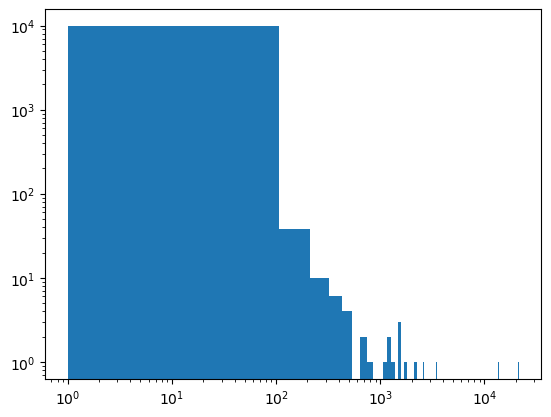

In [13]:
# have a look at the histogram of weights to check that they are not too different
fig, axs = plt.subplots()

axs.hist(weights, bins=200);
axs.set_xscale("log")
axs.set_yscale("log")

### Reaction coordinate model and `descriptor_transform`

In [14]:
# import descriptor_transform for the model
# descriptor_func_ic gives us an internal coordinate representation (i.e. bond lengths, angles and dihedrals)
from state_funcs_mda import descriptor_func_ic, descriptor_func_psi_phi

# and as usual wrapp them to become awaitable
wrapped_transform = asyncmd.trajectory.PyTrajectoryFunctionWrapper(descriptor_func_ic, call_kwargs={"molecule_selection": "protein"})

In [15]:
# get the descriptors for the umbrella sampling trajectory
# (we do this to get the dimension of the descriptors to know the input dimension of our model)
descriptors_for_us = await wrapped_transform(us_traj)

In [16]:
# model architecture definition
# we use a pyramidal ResNet as described in "Machine-guided path sampling to discover mechanisms of molecular self-organization" (Nat.Comput.Sci 2023)

n_lay_pyramid = 5  # number of resunits
n_unit_top = 10  # number of units in the last layer before the log_predictor
dropout_base = 0.3  # dropot fraction in the first layer (will be reduced going to the top)
n_unit_base = cv_ndim = descriptors_for_us.shape[1]  # input dimension
# the factor by which we reduce the number of units per layer (the width) and the dropout fraction
fact = (n_unit_top / n_unit_base)**(1./(n_lay_pyramid))

# create a list of modules to build our pytorch reaction coodrinate model from
modules = []

for i in range(1, n_lay_pyramid + 1):
    modules += [aimmd.pytorch.networks.FFNet(n_in=max(n_unit_top, int(n_unit_base * fact**(i-1))),
                                             n_hidden=[max(n_unit_top, int(n_unit_base * fact**i))],  # 1 hidden layer network
                                             activation=torch.nn.Identity(),
                                             dropout={"0": dropout_base * fact**i}
                                             )
                ]
    print(f"ResUnit {i} is {max(n_unit_top, int(n_unit_base * fact**(i)))} units wide.")
    print(f"Dropout before it is {dropout_base * fact**i}.")
    modules += [aimmd.pytorch.networks.ResNet(n_units=max(n_unit_top, int(n_unit_base * fact**i)),
                                              n_blocks=1)
                ]

# and build the reaction coodrinate model
torch_model = aimmd.pytorch.networks.ModuleStack(n_out=1,  # using a single output we will predict only p_B and use a binomial loss
                                                           # we could have also used n_out=n_states to use a multinomial loss and predict all states,
                                                           # but this is probably only worthwhile if n_states > 2 as it would increase the number of free parameters in the NN
                                                 modules=modules,  # modules is a list of initialized torch.nn.Modules from arcd.pytorch.networks
                                                 )

# move model to GPU if CUDA is available
if torch.cuda.is_available():
    torch_model = torch_model.to('cuda')

# finaly choose and initialize an optimizer to train the model
optimizer = torch.optim.Adam(torch_model.parameters(), lr=1e-3)

ResUnit 1 is 66 units wide.
Dropout before it is 0.18674307214231128.
ResUnit 2 is 41 units wide.
Dropout before it is 0.1162432499771616.
ResUnit 3 is 25 units wide.
Dropout before it is 0.07235873872180604.
ResUnit 4 is 16 units wide.
Dropout before it is 0.045041643884176266.
ResUnit 5 is 10 units wide.
Dropout before it is 0.02803738317757008.


In [17]:
# wrapp the pytorch neural network model in a RCModel class,
# these classes know how to decide if they should train in a self-consistent way
# and they also know how to transform from configurations to descriptors space (because they know about the descriptor_transform) 
# Here we take an ExpectedEfficiencyPytorchRCModel,
# this RCmodel scales the learning rate by the expected efficiency factor (1 - n_TP_true / n_TP_expected)**2
model = aimmd.pytorch.EEScalePytorchRCModelAsync(nnet=torch_model,
                                                 optimizer=optimizer,
                                                 states=[wrapped_C7_eq, wrapped_alphaR],
                                                 ee_params={'lr_0': 1e-3,  
                                                            'lr_min': 5e-5,  # lr_min = lr_0 / 20 is a good choice empirically
                                                            'epochs_per_train': 3,
                                                            'interval': 5,
                                                            'window': 100,
                                                            'batch_size': 8192,
                                                           },
                                                 descriptor_transform=wrapped_transform,
                                                 cache_file=storage,
                                                 )

### Define the sampling scheme

We will first define the shooting point selection, usualy the shooting point selector (or equivalently the choosen selection scheme) determines the acceptance probability for each new trial. Here the shooting point selector determines the weight for each newly generated transition since we are doing TPS from equilibrium shooting points.

We will then use the selector to setup our sampling scheme, which is very simple here as it only consists of one mover (the two way shooting mover). However you can use an arbitray number of movers (potentially defining a probability for each of them), in that case each mover will be picked with the given probability to generate the next trial.

In [18]:
# setup the SP selector object
# it needs the configurations to slect SPs from as asyncmd trajectories and the respective equilibrium weights
# density_adaption decides if we should correct for the density of SPs projected into committor space when picking configurations
selector = aimmdd.spselectors.RCModelSPSelectorFromEQ(trajectories=us_traj, equilibrium_weights=weights, density_adaptation=True)

In [19]:
# setup a list of movers
# since we want to create n_sampler identical samplers it is easiest to use the `Brain.samplers_from_moverlist()` function
# This function will create n_sampler identical PathChainSamplers where the movers for each sampler are
# specified by movers_cls (a list of mover classes) and movers_kwargs (a dict with keyword arguments used for initialization of the movers)
movers_cls = [aimmdd.pathmovers.TwoWayShootingPathMover]
movers_kwargs = [{'states': [wrapped_alphaR, wrapped_C7_eq],
                  'engine_cls': gmx_engine_cls,
                  'engine_kwargs': gmx_engine_kwargs,
                  # NOTE: choose this as short as possible!
                  #       since ala is super-small and commits fast we should make sure
                  #       that most trials reach a state in the first part
                  #       this in turn makes sure that we do not call gromacs multiple times per trial (saving setup time)
                  #       but still ensures that the resulting trajectories are not too long and large
                  #       it also reduces the time needed per step (we need at least walltime_per_part hours per step)
                  #'walltime_per_part': 0.000015625,  # 0.055125 s per part
                  'walltime_per_part': 0.00003125,  # 0.1125 s per part
                  #'walltime_per_part': 0.0000625,  # 0.225 s per part
                  #'walltime_per_part': 0.000125,  # 0.45 s per part
                  #'walltime_per_part': 0.001,  # 3.6 s per part
                  #'walltime_per_part': 0.004,  # 14.4 s per part
                  'T': mdp["ref-t"][0],
                  "sp_selector": selector,  # use the SP selector from the cell above 
                  "max_steps": 500 * 10**5,  # 500 steps * dt (2 fs) = 1 ps
                  }
                 ]

# Note that for full flexibility of the sampling scheme setup we could also use a list of lists with initialized movers
# then however we need the outermost list to be of length n_sampler as shown below
#movers = [[aimmdd.TwoWayShootingPathMover(states=[wrapped_C7_eq, wrapped_alphaR],
#                                          engine_cls=gmx_engine_cls,
#                                          engine_kwargs=gmx_engine_kwargs,
#                                          engine_config=mdp,
#                                          walltime_per_part=0.00003125,
#                                          T=mdp["ref-t"][0],
#                                          sp_selector=selector,
#                                          max_steps=500 * 10**5,
#                                         )
#           ] for i in range(n_samplers)
#         ]

### Trainset

In [20]:
trainset = aimmd.TrainSet(n_states=2)

### Brain tasks

Each task will be run after `interval` finished trials by the brain, you can also define your own tasks to modify the behaviour of the TPS simulation easily (openpathsampling users should think of hooks).

In [21]:
tasks = [
    # the TrainingTask takes care of training the model (or better: reminding the model to decide if it wants to train)
    aimmdd.pathsampling.TrainingTask(model=model, trainset=trainset),
    # the SaveTask saves the model, trainset and brain to storage at specified interval during the simulation
    aimmdd.pathsampling.SaveTask(storage=storage, model=model, trainset=trainset),
    # the DensityCollectionTask takes care of updating the estimate of the density of shooting points
    # projected into committor space
    # It needs to know what the ensemble is we shoot from (e.g. "custom" for a self-defined set of shooting points
    #  or "p_x_TP" if we shoot from previous transitions)
    aimmdd.pathsampling.DensityCollectionTask(model=model,
                                              first_collection=0,
                                              recreate_interval=50,
                                              mode="custom",
                                              trajectories=[us_traj],
                                              trajectory_weights=[weights],
                                              interval=10
                                              ),
         ]

In [22]:
# this is the 'easy' way to setup n_sampler identical samplers (using `samplers_from_moverlist` as promised above)
brain = aimmdd.Brain.samplers_from_moverlist(model=model, workdir=workdir, storage=storage,
                                             n_sampler=n_samplers,
                                             movers_cls=movers_cls, movers_kwargs=movers_kwargs,
                                             samplers_use_same_stepcollection=True,
                                             tasks=tasks)
                                             # Note that we left mover_weights=None at its default, this results
                                             # in uniform weights for all movers

# and this would be the full __init__ call to the brain (given you defined `movers` as above commented out) 
# it gives you full flexibility of setting up every PathChainSamplers individually
#brain = aimmdd.Brain(model=model, workdir=workdir, storage=storage, movers=movers, mover_weights=[[1.], [1.], [1.]], tasks=tasks)

### Note: Depending on your transition path sampling scheme you would need to now provide initial transitions to initialize the TPS, howver here since we shoot from an ensemble of shooting points we can just start the TPS (and ignore the warnings below)

## Run the TPS simulation

In [23]:
# lets see how long it runs
import time

In [24]:
n_steps = 10000
start = time.time()

await brain.run_for_n_steps(n_steps)

end = time.time()
print(f"Running for {n_steps} cummulative MCSteps took {end-start} s (= {(end-start)/60} min).")

(WARNING)aimmd.distributed.pathsampling run_step: Sampler 0: Instep is None. This will only work with sampling schemes that generate their own shooting points.
(WARNING)aimmd.distributed.pathsampling run_step: Sampler 1: Instep is None. This will only work with sampling schemes that generate their own shooting points.
(WARNING)aimmd.distributed.pathsampling run_step: Sampler 2: Instep is None. This will only work with sampling schemes that generate their own shooting points.
(WARNING)aimmd.distributed.pathsampling run_step: Sampler 3: Instep is None. This will only work with sampling schemes that generate their own shooting points.
(WARNING)aimmd.distributed.pathsampling run_step: Sampler 4: Instep is None. This will only work with sampling schemes that generate their own shooting points.


Running for 10000 cummulative MCSteps took 13275.960083723068 s (= 221.26600139538448 min).


In [25]:
brain.total_steps

10000

## Save the last model, trainset and brain to storage
This enables us to do the analysis in a different notebook or continue the TPS simulation from the last step easily.

In [26]:
# save the last model
storage.rcmodels["model_to_continue_with"] = model
storage.save_trainset(trainset)  # the trainset
storage.save_brain(brain)  # and the brain

In [27]:
# properly close the storage to make sure all writes are complete
storage.close()